In [19]:
import os
import logging
import copy

#Set TensorFlow logging level to suppress warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
#Set absl logging level to suppress warnings
logging.getLogger('absl').setLevel(logging.ERROR)

#Standard Data Packages
import pandas as pd
import numpy as np

#Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

#tf and keras
import tensorflow as tf
from keras import models
from keras import layers
from keras import metrics

#Scikit
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn import preprocessing


## Load Data

In [20]:
train_set = pd.read_csv('../data/train_set.csv')
val_set = pd.read_csv('../data/val_set.csv')

In [21]:
features = ["CreditScore", "Geography", "Gender", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary"]

X_train = train_set[features]
Y_train = train_set["Exited"]

X_val = val_set[features]
Y_val = val_set["Exited"]

In [22]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,585,france,female,53.0,2,0.00,2,1.0,1.0,91830.75
1,606,france,male,24.0,2,0.00,1,0.0,1.0,90876.95
2,633,germany,male,44.0,1,118907.60,1,1.0,0.0,47777.15
3,602,germany,male,40.0,2,149961.99,2,1.0,1.0,82696.84
4,645,france,male,31.0,4,132351.29,1,1.0,0.0,151887.16


In [23]:
numeric_features = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]
X_train_numeric = X_train[numeric_features]
X_val_numeric = X_val[numeric_features]

categorical_features = ["Geography", "Gender", "HasCrCard", "IsActiveMember"]
X_train_categorical = X_train[categorical_features]
X_val_categorical = X_val[categorical_features]

In [24]:
display(X_train_numeric.head())
display(X_train_categorical.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,585,53.0,2,0.00,2,91830.75
1,606,24.0,2,0.00,1,90876.95
2,633,44.0,1,118907.60,1,47777.15
3,602,40.0,2,149961.99,2,82696.84
4,645,31.0,4,132351.29,1,151887.16


,Geography,Gender,HasCrCard,IsActiveMember
0,france,female,1.0,1.0
1,france,male,0.0,1.0
2,germany,male,1.0,0.0
3,germany,male,1.0,1.0
4,france,male,1.0,0.0


In [25]:
X_train_numeric = X_train_numeric.to_numpy()
X_train_categorical = X_train_categorical.to_numpy()

X_val_numeric = X_val_numeric.to_numpy()
X_val_categorical = X_val_categorical.to_numpy()

## Build MNN Model

In [26]:
def build_model(hidden_layers = [32], activation = "relu", optimizer = "SGD", learning_rate = 0.01):
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    #add inputs for all features
    credit_score = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "CreditScore")
    geography = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Geography")
    gender = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Gender")
    age = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Age")
    tenure = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Tenure")
    balance = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "Balance")
    numProducts = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "NumOfProducts")
    crCard = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "HasCrCard")
    activeMember = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "IsActiveMember")
    salary = tf.keras.layers.Input(shape = (1, ), dtype = tf.float64, name = "EstimatedSalary")

    #concatenate all features
    features = tf.keras.layers.Concatenate()([credit_score, geography, gender, age, tenure, balance, numProducts, crCard, activeMember, salary])
    
    curr_layer = features

    #add hidden layers based on input
    for units in hidden_layers:
        new_layer = tf.keras.layers.Dense(units = units, activation = activation)(curr_layer)
        curr_layer = new_layer

    #add output layer
    dx = tf.keras.layers.Dense(units = 1, activation = "sigmoid", name = "Dx")(curr_layer)
    
    #configure model
    model = tf.keras.Model(inputs = [credit_score, geography, gender, age, tenure, balance, numProducts, crCard, activeMember, salary], outputs = dx, name = "model2")

    #configure optimizer
    if optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    elif optimizer == "RMS":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate)
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

## MNN Cross Validation 1 (unbalanced)

#### Define Parameters

In [27]:
epoch_list = [15, 20, 30]
batch_list = [32, 64, 128]
layers_list = [[64, 32], [128, 64], [32, 16, 8], [64, 32, 16], [128, 64, 32], [32, 64, 128, 256, 128, 64, 32]]
activation_list = ["relu", "tanh", "elu"]
optimizer_list = ["SGD", "Adam", "RMSProp"]
learning_list = [0.01, 0.001]

#### Fit CV on Train Data and Evaluate on Validation Data

In [11]:
kfold = KFold(n_splits = 3, shuffle = True, random_state = 0)

fold_losses = {}
fold_accs = {}

bestModel = None
best_f1 = 0
best_param = None

for num_epochs in epoch_list:
    for batch_size in batch_list:
        print(f"epoch: {num_epochs}, batch size: {batch_size}")
        for num_layers in layers_list:
            for activation_func in activation_list:
                for optimizer in optimizer_list:
                    for learning_rate in learning_list:
                        #generate fold ids
                        for fold_i, (train_ids, val_ids) in enumerate(kfold.split(X_train_numeric)):    
                            #build model based on CV iterations
                            model = build_model(hidden_layers = num_layers, activation = activation_func, optimizer = optimizer, learning_rate = learning_rate)

                            #extract train data based on current fold ids
                            fold_train_num_features = X_train_numeric[train_ids]
                            fold_train_cat_features = X_train_categorical[train_ids]
                            fold_val_num_features = X_train_numeric[val_ids]
                            fold_val_cat_features = X_train_categorical[val_ids]

                            #normalize train and validation data
                            scaler = preprocessing.MinMaxScaler().fit(fold_train_num_features)
                            fold_train_num_features = scaler.transform(fold_train_num_features)
                            fold_val_num_features = scaler.transform(fold_val_num_features)
                            val_num_features = scaler.transform(X_val_numeric)

                            #encode categorical features
                            val_cat_features = copy.deepcopy(X_val_categorical)
            
                            for i in range(len(categorical_features)):
                                label_encoder = preprocessing.LabelEncoder().fit(fold_train_cat_features[:,i])
                                fold_train_cat_features[:,i] = label_encoder.transform(fold_train_cat_features[:,i])
                                fold_val_cat_features[:,i] = label_encoder.transform(fold_val_cat_features[:,i])
                                val_cat_features[:,i] = label_encoder.transform(X_val_categorical[:,i])
                
                            
                            fold_train_num_features = fold_train_num_features.astype('float64')
                            fold_train_cat_features = fold_train_cat_features.astype('float64')
                            fold_val_num_features = fold_val_num_features.astype('float64')
                            fold_val_cat_features = fold_val_cat_features.astype('float64')
                            val_num_features = val_num_features.astype('float64')
                            val_cat_features = val_cat_features.astype('float64')

                            #fit model on train data
                            model.fit(
                                x = {
                                    "CreditScore": fold_train_num_features[:, 0],
                                    "Age": fold_train_num_features[:, 1],
                                    "Tenure": fold_train_num_features[:, 2],
                                    "Balance": fold_train_num_features[:, 3],
                                    "NumOfProducts": fold_train_num_features[:, 4],
                                    "EstimatedSalary": fold_train_num_features[:, 5],
                                    "Geography": fold_train_cat_features[:, 0],
                                    "Gender": fold_train_cat_features[:, 1],
                                    "HasCrCard": fold_train_cat_features[:, 2],
                                    "IsActiveMember": fold_train_cat_features[:, 3]
                                },
                                y = Y_train[train_ids],
                                epochs = num_epochs,
                                batch_size = batch_size,
                                validation_data = (
                                    {
                                        "CreditScore": fold_val_num_features[:, 0],
                                        "Age": fold_val_num_features[:, 1],
                                        "Tenure": fold_val_num_features[:, 2],
                                        "Balance": fold_val_num_features[:, 3],
                                        "NumOfProducts": fold_val_num_features[:, 4],
                                        "EstimatedSalary": fold_val_num_features[:, 5],
                                        "Geography": fold_val_cat_features[:, 0],
                                        "Gender": fold_val_cat_features[:, 1],
                                        "HasCrCard": fold_val_cat_features[:, 2],
                                        "IsActiveMember": fold_val_cat_features[:, 3]
                                    },
                                    Y_train[val_ids]),
                                verbose = 0)

                            #make predictions on validation data
                            predict_val = model.predict(
                                {
                                    "CreditScore": val_num_features[:, 0],
                                    "Age": val_num_features[:, 1],
                                    "Tenure": val_num_features[:, 2],
                                    "Balance": val_num_features[:, 3],
                                    "NumOfProducts": val_num_features[:, 4],
                                    "EstimatedSalary": val_num_features[:, 5],
                                    "Geography": val_cat_features[:, 0],
                                    "Gender": val_cat_features[:, 1],
                                    "HasCrCard": val_cat_features[:, 2],
                                    "IsActiveMember": val_cat_features[:, 3]
                                },
                            verbose = 0)

                            #convert probability to labels
                            predict_val[predict_val <= 0.5] = 0
                            predict_val[predict_val > 0.5] = 1

                            #calculate f1 score
                            f1_score = metrics.f1_score(Y_val, predict_val)

                            #update best parameters and f1 score if necessary
                            if round(f1_score, 4) > round(best_f1, 4):
                                print("New Best Model")
        
                                print(f"Epochs: {num_epochs}, Batch Size: {batch_size}, Layers: {str(num_layers)}, Activation: {activation_func}, Optimizer: {optimizer}, Learning Rate: {learning_rate}, Fold: {fold_i}, F1 Score: {f1_score:.3f}")
                                best_param = (num_epochs, batch_size, num_layers, activation_func, optimizer, learning_rate)
                                bestModel = model
                                best_f1 = f1_score

epoch: 15, batch size: 32
New Best Model
Epochs: 15, Batch Size: 32, Layers: [64, 32], Activation: relu, Optimizer: SGD, Learning Rate: 0.01, Fold: 0, F1 Score: 0.649
New Best Model
Epochs: 15, Batch Size: 32, Layers: [64, 32], Activation: relu, Optimizer: RMSProp, Learning Rate: 0.01, Fold: 0, F1 Score: 0.658
New Best Model
Epochs: 15, Batch Size: 32, Layers: [64, 32], Activation: elu, Optimizer: Adam, Learning Rate: 0.01, Fold: 0, F1 Score: 0.659
New Best Model
Epochs: 15, Batch Size: 32, Layers: [128, 64], Activation: relu, Optimizer: RMSProp, Learning Rate: 0.01, Fold: 0, F1 Score: 0.660
New Best Model
Epochs: 15, Batch Size: 32, Layers: [128, 64], Activation: relu, Optimizer: RMSProp, Learning Rate: 0.001, Fold: 0, F1 Score: 0.661
New Best Model
Epochs: 15, Batch Size: 32, Layers: [128, 64, 32], Activation: relu, Optimizer: RMSProp, Learning Rate: 0.01, Fold: 0, F1 Score: 0.664
New Best Model
Epochs: 15, Batch Size: 32, Layers: [128, 64, 32], Activation: elu, Optimizer: Adam, Lear

#### Best Parameters from CV

In [12]:
print(f"Best Score: {best_f1}, Best Param: {str(best_param)}")

Best Score: 0.6658389838601853, Best Param: (30, 64, [32, 64, 128, 256, 128, 64, 32], 'relu', 'SGD', 0.01)


## MNN Best Model (unbalanced)

#### Load Data

In [28]:
train_norm_set = pd.read_csv('../data/train_norm_set.csv')
val_norm_set = pd.read_csv('../data/val_norm_set.csv')

X_train_norm = train_norm_set[features]
Y_train_norm = train_norm_set["Exited"]

X_val_norm = val_norm_set[features]
Y_val_norm = val_norm_set["Exited"]

#change all features' types to float64 for model
X_train_norm = X_train_norm.astype("float64")
X_val_norm = X_val_norm.astype("float64")

#### Fit and Evaluate

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 CreditScore (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Geography (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Gender (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                             

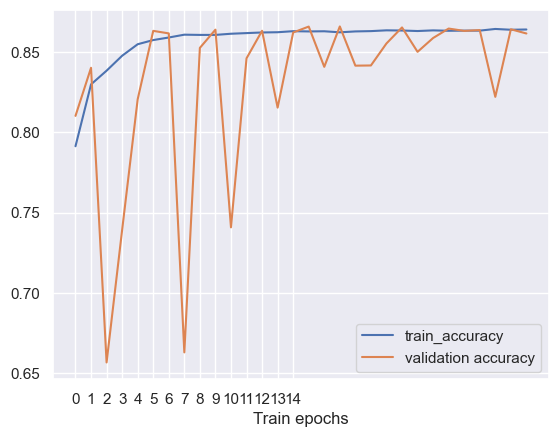

,loss,accuracy,val_loss,val_accuracy
0,0.469207,0.791254,0.421899,0.810143
1,0.401547,0.829748,0.386612,0.840076
2,0.382407,0.838266,0.611788,0.656723
3,0.357101,0.847563,0.506179,0.739189
4,0.341924,0.854722,0.456290,0.820484
5,0.336370,0.857318,0.329719,0.863041
6,0.333976,0.858911,0.331090,0.861465
7,0.331810,0.860668,0.650904,0.662984
8,0.330478,0.860521,0.349734,0.852457
9,0.329345,0.860530,0.328288,0.863788


In [29]:
#build model
mnn_best_unbalanced = build_model(
    hidden_layers = [32, 64, 128, 256, 128, 64, 32],
    activation = "relu",
    optimizer = "SGD", 
    learning_rate = 0.01)

mnn_best_unbalanced.summary()

#fit on train data and evaluate on validation data
best_unbalanced_history = mnn_best_unbalanced.fit(
    x = {
        "CreditScore": X_train_norm[["CreditScore"]],
        "Geography": X_train_norm[["Geography"]],
        "Gender": X_train_norm[["Gender"]],
        "Age": X_train_norm[["Age"]],
        "Tenure": X_train_norm[["Tenure"]],
        "Balance": X_train_norm[["Balance"]],
        "NumOfProducts": X_train_norm[["NumOfProducts"]],
        "HasCrCard": X_train_norm[["HasCrCard"]],
        "IsActiveMember": X_train_norm[["IsActiveMember"]],
        "EstimatedSalary": X_train_norm[["EstimatedSalary"]],
    },
    y = Y_train_norm,
    epochs = 30,
    batch_size = 64,
    validation_data = (
        {
            "CreditScore": X_val_norm[["CreditScore"]],
            "Geography": X_val_norm[["Geography"]],
            "Gender": X_val_norm[["Gender"]],
            "Age": X_val_norm[["Age"]],
            "Tenure": X_val_norm[["Tenure"]],
            "Balance": X_val_norm[["Balance"]],
            "NumOfProducts": X_val_norm[["NumOfProducts"]],
            "HasCrCard": X_val_norm[["HasCrCard"]],
            "IsActiveMember": X_val_norm[["IsActiveMember"]],
            "EstimatedSalary": X_val_norm[["EstimatedSalary"]],
        },
        Y_val_norm),
    verbose = 0)

#print results
train_accuracy = best_unbalanced_history.history["accuracy"]
val_accuracy = best_unbalanced_history.history["val_accuracy"]
plt.plot(train_accuracy, label = "train_accuracy")
plt.plot(val_accuracy, label = "validation accuracy")
plt.xticks(range(num_epochs))
plt.xlabel("Train epochs")
plt.legend()
plt.show()

best_unbalanced_history = pd.DataFrame(best_unbalanced_history.history)
display(best_unbalanced_history)

#### Make Predictions and Evaluate on Validation Data

1548/1548 [==============================] - 1s 404us/step
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     39041
           1       0.80      0.46      0.58     10470

    accuracy                           0.86     49511
   macro avg       0.84      0.71      0.75     49511
weighted avg       0.86      0.86      0.85     49511



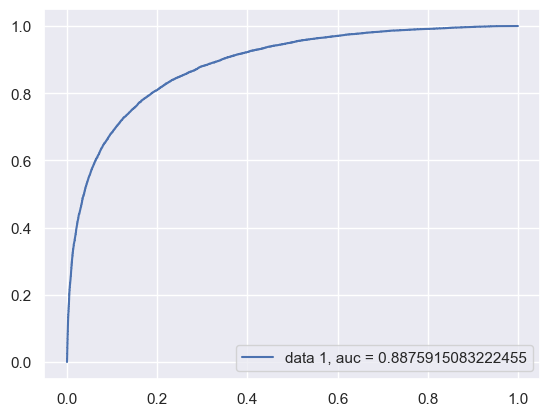

In [30]:
#make predictions
predict_val = mnn_best_unbalanced.predict({
    "CreditScore": X_val_norm[["CreditScore"]],
    "Geography": X_val_norm[["Geography"]],
    "Gender": X_val_norm[["Gender"]],
    "Age": X_val_norm[["Age"]],
    "Tenure": X_val_norm[["Tenure"]],
    "Balance": X_val_norm[["Balance"]],
    "NumOfProducts": X_val_norm[["NumOfProducts"]],
    "HasCrCard": X_val_norm[["HasCrCard"]],
    "IsActiveMember": X_val_norm[["IsActiveMember"]],
    "EstimatedSalary": X_val_norm[["EstimatedSalary"]],
})

#ROC Curve and AUC
fpr, tpr, _ = metrics.roc_curve(Y_val_norm,  predict_val)
auc = metrics.roc_auc_score(Y_val_norm, predict_val)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

#convert probability to labels
predict_val[predict_val <= 0.5] = 0
predict_val[predict_val > 0.5] = 1

#print metrics
print(metrics.classification_report(Y_val_norm, predict_val))

plt.show()

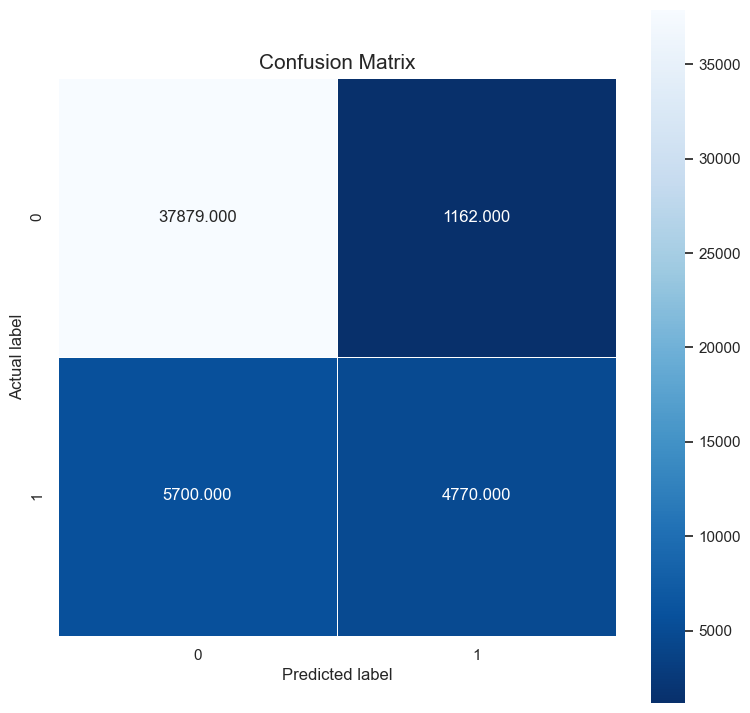

In [31]:
confusion_matrix = metrics.confusion_matrix(Y_val_norm, predict_val)

plt.figure(figsize = (9,9))
sns.heatmap(confusion_matrix, annot = True, fmt = ".3f", linewidths=.5, square = True, cmap = "Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix", size = 15)

plt.show()

In [25]:
mnn_best_unbalanced.save("../models/MNN_best_unbalanced.keras")

## MNN Cross Validation 2 (undersampled balanced dataset)

#### Load Data

In [32]:
train_set_balanced = pd.read_csv('../data/train_set_balanced.csv')
val_set = pd.read_csv('../data/val_set.csv')

X_train_balanced = train_set_balanced[features]
Y_train_balanced = train_set_balanced["Exited"]

X_val = val_set[features]
Y_val = val_set["Exited"]

(48902, 12)


In [36]:
print(train_set_balanced.shape)

(48902, 12)


In [37]:
train_set_balanced.head()

,Unnamed: 0,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,83999,679,france,male,38.0,8,0.0,2,0.0,1.0,152879.36,0
1,56763,581,france,male,39.0,2,0.0,1,1.0,1.0,52827.51,0
2,16162,685,spain,male,35.0,8,0.0,2,0.0,0.0,74838.64,0
3,110897,613,france,male,38.0,7,0.0,2,0.0,0.0,85982.39,0
4,113861,597,france,female,23.0,1,0.0,2,0.0,0.0,126565.21,0


In [33]:
X_train_balanced_numeric = X_train_balanced[numeric_features]
X_val_numeric = X_val[numeric_features]

X_train_balanced_categorical = X_train_balanced[categorical_features]
X_val_categorical = X_val[categorical_features]

In [34]:
X_train_balanced_numeric = X_train_balanced_numeric.to_numpy()
X_train_balanced_categorical = X_train_balanced_categorical.to_numpy()

X_val_numeric = X_val_numeric.to_numpy()
X_val_categorical = X_val_categorical.to_numpy()

#### Fit CV on Train Data and Evaluate on Validation Data

In [38]:
kfold = KFold(n_splits = 3, shuffle = True, random_state = 0)

bestModel = None
best_f1 = 0
best_param = None

for num_epochs in epoch_list:
    for batch_size in batch_list:
        print(f"epoch: {num_epochs}, batch size: {batch_size}")
        for num_layers in layers_list:
            for activation_func in activation_list:
                for optimizer in optimizer_list:
                    for learning_rate in learning_list:
                        #generate fold ids
                        for fold_i, (train_ids, val_ids) in enumerate(kfold.split(X_train_balanced_numeric)):    
                            #build model based on CV iterations
                            model = build_model(hidden_layers = num_layers, activation = activation_func, optimizer = optimizer, learning_rate = learning_rate)

                            #extract train data based on current fold ids
                            fold_train_num_features = X_train_balanced_numeric[train_ids]
                            fold_train_cat_features = X_train_balanced_categorical[train_ids]
                            fold_val_num_features = X_train_balanced_numeric[val_ids]
                            fold_val_cat_features = X_train_balanced_categorical[val_ids]

                            #normalize train and validation data
                            scaler = preprocessing.MinMaxScaler().fit(fold_train_num_features)
                            fold_train_num_features = scaler.transform(fold_train_num_features)
                            fold_val_num_features = scaler.transform(fold_val_num_features)
                            val_num_features = scaler.transform(X_val_numeric)

                            #encode categorical features
                            val_cat_features = copy.deepcopy(X_val_categorical)
            
                            for i in range(len(categorical_features)):
                                label_encoder = preprocessing.LabelEncoder().fit(fold_train_cat_features[:,i])
                                fold_train_cat_features[:,i] = label_encoder.transform(fold_train_cat_features[:,i])
                                fold_val_cat_features[:,i] = label_encoder.transform(fold_val_cat_features[:,i])
                                val_cat_features[:,i] = label_encoder.transform(X_val_categorical[:,i])
                
                            
                            fold_train_num_features = fold_train_num_features.astype('float64')
                            fold_train_cat_features = fold_train_cat_features.astype('float64')
                            fold_val_num_features = fold_val_num_features.astype('float64')
                            fold_val_cat_features = fold_val_cat_features.astype('float64')
                            val_num_features = val_num_features.astype('float64')
                            val_cat_features = val_cat_features.astype('float64')

                            #fit model on train data
                            model.fit(
                                x = {
                                    "CreditScore": fold_train_num_features[:, 0],
                                    "Age": fold_train_num_features[:, 1],
                                    "Tenure": fold_train_num_features[:, 2],
                                    "Balance": fold_train_num_features[:, 3],
                                    "NumOfProducts": fold_train_num_features[:, 4],
                                    "EstimatedSalary": fold_train_num_features[:, 5],
                                    "Geography": fold_train_cat_features[:, 0],
                                    "Gender": fold_train_cat_features[:, 1],
                                    "HasCrCard": fold_train_cat_features[:, 2],
                                    "IsActiveMember": fold_train_cat_features[:, 3]
                                },
                                y = Y_train_balanced[train_ids],
                                epochs = num_epochs,
                                batch_size = batch_size,
                                validation_data = (
                                    {
                                        "CreditScore": fold_val_num_features[:, 0],
                                        "Age": fold_val_num_features[:, 1],
                                        "Tenure": fold_val_num_features[:, 2],
                                        "Balance": fold_val_num_features[:, 3],
                                        "NumOfProducts": fold_val_num_features[:, 4],
                                        "EstimatedSalary": fold_val_num_features[:, 5],
                                        "Geography": fold_val_cat_features[:, 0],
                                        "Gender": fold_val_cat_features[:, 1],
                                        "HasCrCard": fold_val_cat_features[:, 2],
                                        "IsActiveMember": fold_val_cat_features[:, 3]
                                    },
                                    Y_train_balanced[val_ids]),
                                verbose = 0)

                            #make predictions on validation data
                            predict_val = model.predict(
                                {
                                    "CreditScore": val_num_features[:, 0],
                                    "Age": val_num_features[:, 1],
                                    "Tenure": val_num_features[:, 2],
                                    "Balance": val_num_features[:, 3],
                                    "NumOfProducts": val_num_features[:, 4],
                                    "EstimatedSalary": val_num_features[:, 5],
                                    "Geography": val_cat_features[:, 0],
                                    "Gender": val_cat_features[:, 1],
                                    "HasCrCard": val_cat_features[:, 2],
                                    "IsActiveMember": val_cat_features[:, 3]
                                },
                            verbose = 0)

                            #convert probability to labels
                            predict_val[predict_val <= 0.5] = 0
                            predict_val[predict_val > 0.5] = 1

                            #calculate f1 score
                            f1_score = metrics.f1_score(Y_val, predict_val)

                            #update best parameters and f1 score if necessary
                            if round(f1_score, 4) > round(best_f1, 4):
                                print("New Best Model")
        
                                print(f"Epochs: {num_epochs}, Batch Size: {batch_size}, Layers: {str(num_layers)}, Activation: {activation_func}, Optimizer: {optimizer}, Learning Rate: {learning_rate}, Fold: {fold_i}, F1 Score: {f1_score:.3f}")
                                best_param = (num_epochs, batch_size, num_layers, activation_func, optimizer, learning_rate)
                                bestModel = model
                                best_f1 = f1_score

epoch: 15, batch size: 32
New Best Model
Epochs: 15, Batch Size: 32, Layers: [64, 32], Activation: relu, Optimizer: SGD, Learning Rate: 0.01, Fold: 0, F1 Score: 0.600
New Best Model
Epochs: 15, Batch Size: 32, Layers: [64, 32], Activation: relu, Optimizer: SGD, Learning Rate: 0.01, Fold: 2, F1 Score: 0.614
New Best Model
Epochs: 15, Batch Size: 32, Layers: [64, 32], Activation: relu, Optimizer: Adam, Learning Rate: 0.01, Fold: 0, F1 Score: 0.636
New Best Model
Epochs: 15, Batch Size: 32, Layers: [64, 32], Activation: relu, Optimizer: Adam, Learning Rate: 0.001, Fold: 0, F1 Score: 0.638
New Best Model
Epochs: 15, Batch Size: 32, Layers: [64, 32], Activation: elu, Optimizer: Adam, Learning Rate: 0.01, Fold: 2, F1 Score: 0.650
New Best Model
Epochs: 15, Batch Size: 32, Layers: [128, 64], Activation: tanh, Optimizer: Adam, Learning Rate: 0.01, Fold: 2, F1 Score: 0.651
New Best Model
Epochs: 15, Batch Size: 32, Layers: [128, 64, 32], Activation: elu, Optimizer: Adam, Learning Rate: 0.01, Fo

#### Best Parameters from CV

In [39]:
print(f"Best Score: {best_f1}, Best Param: {str(best_param)}")

Best Score: 0.6603650302739905, Best Param: (30, 32, [128, 64], 'elu', 'Adam', 0.01)


## MNN Best Model (undersampled balanced dataset)

In [40]:
train_norm_set = pd.read_csv('../data/train_norm_set.csv')
val_norm_set = pd.read_csv('../data/val_norm_set.csv')

X_train_norm = train_norm_set[features]
Y_train_norm = train_norm_set["Exited"]

X_val_norm = val_norm_set[features]
Y_val_norm = val_norm_set["Exited"]

#change all features' types to float64 for model
X_train_norm = X_train_norm.astype("float64")
X_val_norm = X_val_norm.astype("float64")

#### Fit and Evaluate

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 CreditScore (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Geography (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Gender (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                             

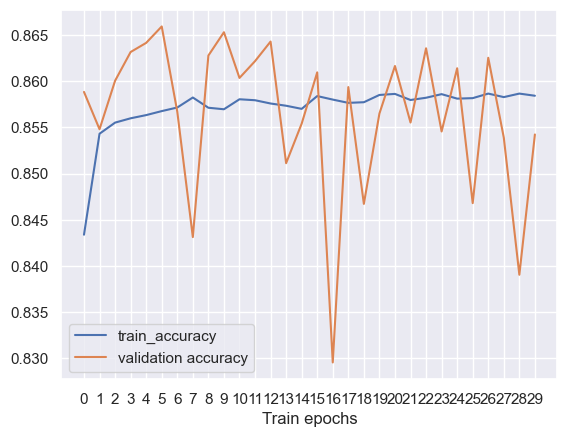

,loss,accuracy,val_loss,val_accuracy
0,0.364376,0.843382,0.336199,0.858839
1,0.345532,0.854315,0.364666,0.854800
2,0.343946,0.855518,0.336757,0.860051
3,0.341357,0.855985,0.329521,0.863162
4,0.340255,0.856332,0.325930,0.864151
5,0.340360,0.856764,0.328474,0.865929
6,0.339528,0.857154,0.342553,0.856699
7,0.339139,0.858236,0.356730,0.843126
8,0.338947,0.857128,0.328360,0.862778
9,0.338544,0.856964,0.325935,0.865303


In [41]:
#build model
mnn_best_balanced = build_model(
    hidden_layers = [128, 64],
    activation = "elu",
    optimizer = "Adam", 
    learning_rate = 0.01)

mnn_best_balanced.summary()

#fit on train data and evaluate on validation data
best_balanced_history = mnn_best_balanced.fit(
    x = {
        "CreditScore": X_train_norm[["CreditScore"]],
        "Geography": X_train_norm[["Geography"]],
        "Gender": X_train_norm[["Gender"]],
        "Age": X_train_norm[["Age"]],
        "Tenure": X_train_norm[["Tenure"]],
        "Balance": X_train_norm[["Balance"]],
        "NumOfProducts": X_train_norm[["NumOfProducts"]],
        "HasCrCard": X_train_norm[["HasCrCard"]],
        "IsActiveMember": X_train_norm[["IsActiveMember"]],
        "EstimatedSalary": X_train_norm[["EstimatedSalary"]],
    },
    y = Y_train_norm,
    epochs = 30,
    batch_size = 32,
    validation_data = (
        {
            "CreditScore": X_val_norm[["CreditScore"]],
            "Geography": X_val_norm[["Geography"]],
            "Gender": X_val_norm[["Gender"]],
            "Age": X_val_norm[["Age"]],
            "Tenure": X_val_norm[["Tenure"]],
            "Balance": X_val_norm[["Balance"]],
            "NumOfProducts": X_val_norm[["NumOfProducts"]],
            "HasCrCard": X_val_norm[["HasCrCard"]],
            "IsActiveMember": X_val_norm[["IsActiveMember"]],
            "EstimatedSalary": X_val_norm[["EstimatedSalary"]],
        },
        Y_val_norm),
    verbose = 0)

#print results
train_accuracy = best_balanced_history.history["accuracy"]
val_accuracy = best_balanced_history.history["val_accuracy"]
plt.plot(train_accuracy, label = "train_accuracy")
plt.plot(val_accuracy, label = "validation accuracy")
plt.xticks(range(num_epochs))
plt.xlabel("Train epochs")
plt.legend()
plt.show()

best_balanced_history = pd.DataFrame(best_balanced_history.history)
display(best_balanced_history)

#### Make Predictions and Evaluate on Validation Data

1548/1548 [==============================] - 1s 348us/step
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     39041
           1       0.84      0.38      0.53     10470

    accuracy                           0.85     49511
   macro avg       0.85      0.68      0.72     49511
weighted avg       0.85      0.85      0.83     49511



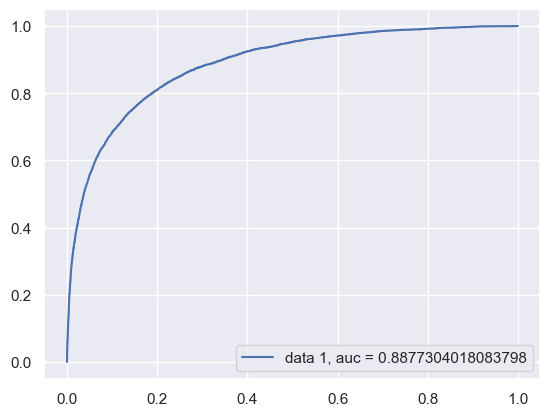

In [42]:
#make predictions
predict_val = mnn_best_balanced.predict({
    "CreditScore": X_val_norm[["CreditScore"]],
    "Geography": X_val_norm[["Geography"]],
    "Gender": X_val_norm[["Gender"]],
    "Age": X_val_norm[["Age"]],
    "Tenure": X_val_norm[["Tenure"]],
    "Balance": X_val_norm[["Balance"]],
    "NumOfProducts": X_val_norm[["NumOfProducts"]],
    "HasCrCard": X_val_norm[["HasCrCard"]],
    "IsActiveMember": X_val_norm[["IsActiveMember"]],
    "EstimatedSalary": X_val_norm[["EstimatedSalary"]],
})

#ROC Curve and AUC
fpr, tpr, _ = metrics.roc_curve(Y_val_norm,  predict_val)
auc = metrics.roc_auc_score(Y_val_norm, predict_val)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)

#convert probability to labels
predict_val[predict_val <= 0.5] = 0
predict_val[predict_val > 0.5] = 1

#print metrics
print(metrics.classification_report(Y_val_norm, predict_val))

plt.show()

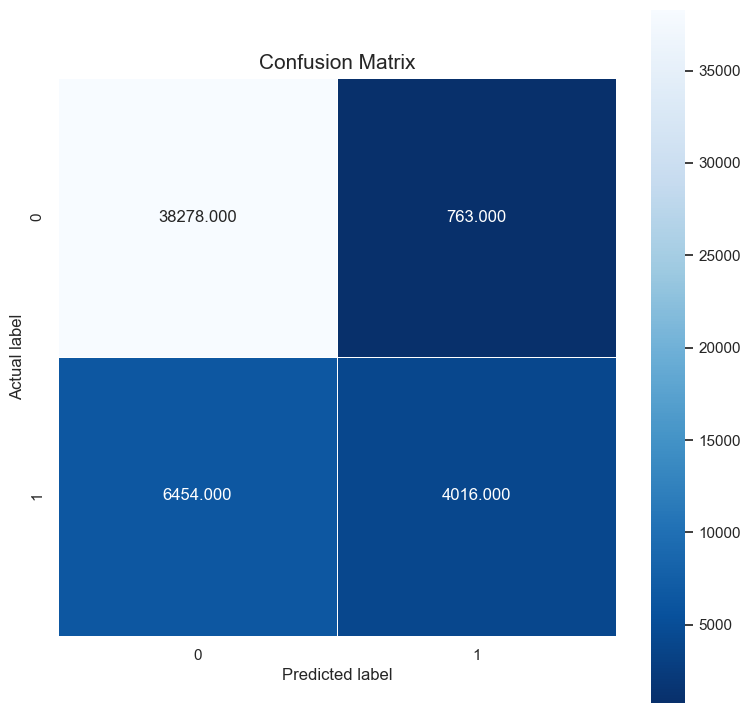

In [43]:
confusion_matrix = metrics.confusion_matrix(Y_val_norm, predict_val)

plt.figure(figsize = (9,9))
sns.heatmap(confusion_matrix, annot = True, fmt = ".3f", linewidths=.5, square = True, cmap = "Blues_r")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix", size = 15)

plt.show()

In [44]:
mnn_best_balanced.save("../models/MNN_best_balanced.keras")